In [2]:
from __future__ import division

import numpy as np
import os, sys
from PIL import Image
import pandas as pd
import json
import pickle

from matplotlib import pylab, mlab, pyplot
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.path import Path
import matplotlib.patches as patches
%matplotlib inline

from IPython.core.pylabtools import figsize, getfigs

import seaborn as sns
from sklearn.model_selection import StratifiedKFold

import random

from scipy.stats import norm
from IPython.display import clear_output

import copy
import importlib


### Add Paths

## root paths
curr_dir = os.getcwd()
proj_dir = os.path.abspath(os.path.join(curr_dir,'..')) ## u\e relative paths

## add helpers to python path
import sys
if os.path.join(proj_dir, 'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir, 'stimuli'))

## custom helper modules
import blockworld_helpers as utils

/Users/will/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# setup
block_dims = [(2,1),(1,2)]
block_colors = ['#B32F0A','#0A2FB3']
black = ['#000000','#000000'] # used to display silhouettes
grey = ['#333333','#333333']
world_width = 8
world_height = 8
world_center = int((world_width-1)/2)


In [4]:
silhouette_superset = pd.read_pickle("./tower_4_block_unique_silhouettes/tower_4_block_unique_silhouettes.pkl")

Goal:
10 annotations total of each stim.
Each participant should annotate a small number of towers (say less than 40).
We should be able to check if different contexts change the annotations.


Partition towers into 5 sets of 26 with roughly equal numbers of tall/ wide/ neither.
Collect annotations from 5 ppts for each set.
Find 2 such partitions.

In [5]:
groups = silhouette_superset[['tower_number_str','group']]
groups['group'].value_counts()

neither    94
wide       18
tall       18
Name: group, dtype: int64

We have 18 wide and 18 tall towers.
So each set should have 3 or 4 wides and 3 or 4 tall.

In [6]:
# neither = list(groups.loc[groups['group'] == 'neither','tower_number_str'])
# wide = list(groups.loc[groups['group'] == 'wide','tower_number_str'])
# tall = list(groups.loc[groups['group'] == 'tall','tower_number_str'])

In [7]:
n_families = 2
n_splits = 5
X = silhouette_superset['tower_number_str']
y = silhouette_superset['group']

for i in range(0, n_families):
    
    # set up partitioning
    skf = StratifiedKFold(n_splits=n_splits, 
                          random_state=i, 
                          shuffle=True) # tie random state to group num
    
    # apply partitioning and save to df
    for split_num, (train_index, test_index) in enumerate(skf.split(X, y)):
        silhouette_superset.loc[test_index,'family_'+str(i)] = split_num
#         print(groups.loc[test_index])

# silhouette_superset

,silhouette_str,index,blocks_above_ground,fully_connected,fully_connected_diag,n_blocks,silhouette,stim,stim_tuple,tower_height,tower_width,two_h_two_v,tower_number,tower_number_str,tower_name,group,family_0,family_1
0,0000000000000000000000000000000000000000000000...,1385,1,True,True,4,"[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, ...","[{'x': 0, 'y': 0, 'height': 2, 'width': 1}, {'...","((0, 0, 2, 1), (1, 0, 1, 2), (3, 0, 2, 1), (1,...",2,4,True,0,000,tower_4_block_unique_silhouette_000,neither,0.0,2.0
1,0000000000000000000000000000000000000000000100...,1249,2,True,True,4,"[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, ...","[{'x': 0, 'y': 0, 'height': 2, 'width': 1}, {'...","((0, 0, 2, 1), (2, 0, 1, 2), (1, 1, 1, 2), (3,...",3,4,True,1,001,tower_4_block_unique_silhouette_001,wide,2.0,2.0
2,0000000000000000000000000000000000000000001000...,791,2,True,True,4,"[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, ...","[{'x': 1, 'y': 0, 'height': 1, 'width': 2}, {'...","((1, 0, 1, 2), (3, 0, 2, 1), (0, 1, 1, 2), (2,...",3,4,True,2,002,tower_4_block_unique_silhouette_002,wide,1.0,0.0
3,0000000000000000000000000000000000000000001100...,1362,1,True,True,4,"[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, ...","[{'x': 0, 'y': 0, 'height': 1, 'width': 2}, {'...","((0, 0, 1, 2), (2, 0, 2, 1), (3, 0, 2, 1), (2,...",3,4,True,3,003,tower_4_block_unique_silhouette_003,neither,1.0,1.0
4,0000000000000000000000000000000000000000001100...,605,1,True,True,4,"[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, ...","[{'x': 0, 'y': 0, 'height': 2, 'width': 1}, {'...","((0, 0, 2, 1), (1, 0, 1, 2), (3, 0, 2, 1), (2,...",3,4,True,4,004,tower_4_block_unique_silhouette_004,neither,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,0000000000000000110000001000000010000000100000...,308,3,True,True,4,"[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, ...","[{'x': 0, 'y': 0, 'height': 1, 'width': 2}, {'...","((0, 0, 1, 2), (0, 1, 2, 1), (0, 3, 2, 1), (0,...",6,2,True,125,125,tower_4_block_unique_silhouette_125,tall,3.0,0.0
126,0000000000000000110000001000000010000000110000...,1336,3,True,True,4,"[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, ...","[{'x': 1, 'y': 0, 'height': 2, 'width': 1}, {'...","((1, 0, 2, 1), (0, 2, 1, 2), (0, 3, 2, 1), (0,...",6,2,True,126,126,tower_4_block_unique_silhouette_126,tall,1.0,2.0
127,0000000000000000110000001000000010000000110000...,696,3,True,True,4,"[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, ...","[{'x': 0, 'y': 0, 'height': 2, 'width': 1}, {'...","((0, 0, 2, 1), (0, 2, 1, 2), (0, 3, 2, 1), (0,...",6,2,True,127,127,tower_4_block_unique_silhouette_127,tall,4.0,1.0
128,0000000000000000110000001100000001000000010000...,1072,3,True,True,4,"[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, ...","[{'x': 1, 'y': 0, 'height': 2, 'width': 1}, {'...","((1, 0, 2, 1), (1, 2, 2, 1), (0, 4, 1, 2), (0,...",6,2,True,128,128,tower_4_block_unique_silhouette_128,tall,4.0,3.0


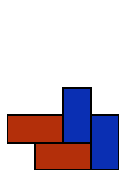

wide


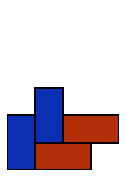

wide


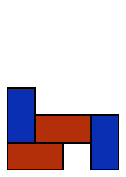

wide


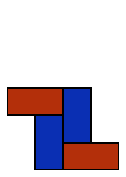

wide


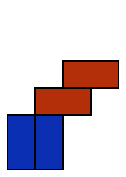

neither


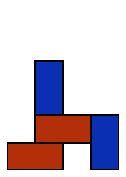

neither


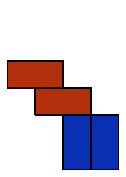

neither


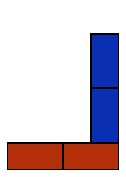

neither


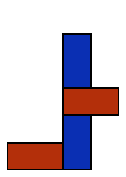

neither


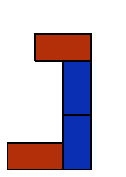

neither


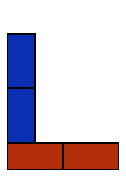

neither


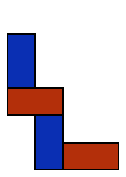

neither


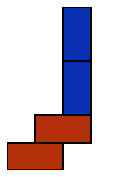

neither


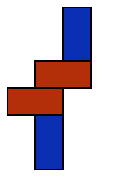

neither


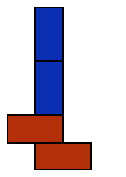

neither


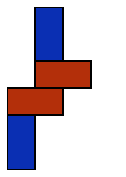

neither


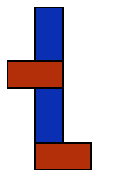

neither


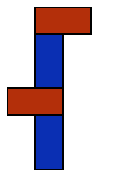

neither


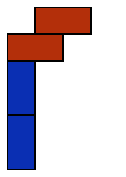

neither


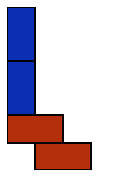

neither


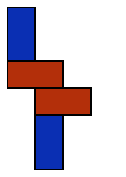

neither


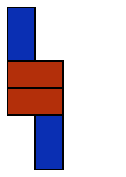

tall


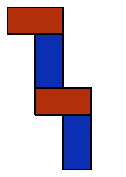

neither


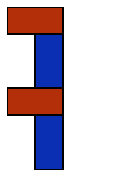

tall


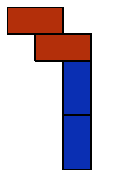

neither


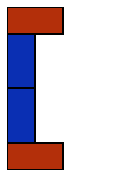

tall


In [7]:
# verify
if False:
    family = 1
    split = 0

    tower_worlds = [utils.worldify(w,
                                   block_dims = block_dims, 
                                   block_colors = block_colors)\
                        for w in silhouette_superset.groupby('family_'+str(family)).get_group(split)['stim']]

    for i, w in enumerate(tower_worlds):
        fig = utils.draw_tower(w)
        print(silhouette_superset.groupby('family_'+str(family)).get_group(split).reset_index(split).loc[i,'group'])

## To run multiple versions, upload the same metadate to separate collections, and update stimColName in configs accordingly

In [65]:
experiment_name = 'ca_prior_elicitation_4_block_unique_silhouettes_procedural'
# experiment_name = 'ca_prior_elicitation_4_block_unique_silhouettes_categorization'
versionInd = 0

In [66]:
# connect to mongo

import pymongo as pm

# set vars 
auth = pd.read_csv('auth.txt', header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'cogtoolslab.org' ## experiment server ip address

conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1')
db = conn['stimuli']
coll = db[experiment_name]

In [67]:
# convert to lists of stimulus names

metadata = []

for f in range(0, n_families):
    for s in range(0,n_splits):
        stim_numbers = list(silhouette_superset.groupby('family_'+str(f)).get_group(s)['tower_number_str'])
#         print(stim_numbers)
        metadata.append(
            {
                'partitionFamily': f,
                'splitNumber': s,
                'stimNumbers': stim_numbers,
                'ntrials': len(stim_numbers),
                'stimGroups': {n: silhouette_superset.groupby('family_'+str(f)).get_group(s).reset_index().loc[i,'group'] for i, n in enumerate(stim_numbers)},
                'numGames': 0,
                'games': [],
                'experimentType': 'prior_elicitation',
                'experimentName': experiment_name,
                's3_bucket': 'lax-tower-4-block-unique-silhouettes-json',
                'versionInd': versionInd
            })
        
metadata

[{'partitionFamily': 0,
  'splitNumber': 0,
  'stimNumbers': ['000',
   '007',
   '009',
   '011',
   '019',
   '023',
   '025',
   '029',
   '034',
   '041',
   '049',
   '053',
   '060',
   '061',
   '062',
   '065',
   '068',
   '072',
   '076',
   '081',
   '084',
   '100',
   '106',
   '113',
   '115',
   '129'],
  'ntrials': 26,
  'stimGroups': {'000': 'neither',
   '007': 'neither',
   '009': 'neither',
   '011': 'wide',
   '019': 'wide',
   '023': 'wide',
   '025': 'wide',
   '029': 'neither',
   '034': 'neither',
   '041': 'neither',
   '049': 'neither',
   '053': 'neither',
   '060': 'neither',
   '061': 'neither',
   '062': 'neither',
   '065': 'neither',
   '068': 'neither',
   '072': 'neither',
   '076': 'neither',
   '081': 'neither',
   '084': 'neither',
   '100': 'tall',
   '106': 'neither',
   '113': 'neither',
   '115': 'tall',
   '129': 'tall'},
  'numGames': 0,
  'games': [],
  'experimentType': 'prior_elicitation',
  'experimentName': 'ca_prior_elicitation_4_block_

In [68]:
experiment_name

'ca_prior_elicitation_4_block_unique_silhouettes_procedural'

In [69]:
really_run = True;

if really_run:
    db.drop_collection(experiment_name)

In [70]:
## now, iterate through each version and insert into mongo
## loop through list of records and insert each into collection
reallyRun = 1
if reallyRun:
    for (i,j) in enumerate(metadata):        
        coll.insert_one(j)
        print('Inserted version {} of stimDict.'.format(j['versionInd']))
        clear_output(wait=True)

else:
    print('Did not insert any new data.')

Inserted version 0 of stimDict.


In [71]:
coll.find_one()

{'_id': ObjectId('610830f18ad19cd87c7e428d'),
 'partitionFamily': 0,
 'splitNumber': 0,
 'stimNumbers': ['000',
  '007',
  '009',
  '011',
  '019',
  '023',
  '025',
  '029',
  '034',
  '041',
  '049',
  '053',
  '060',
  '061',
  '062',
  '065',
  '068',
  '072',
  '076',
  '081',
  '084',
  '100',
  '106',
  '113',
  '115',
  '129'],
 'ntrials': 26,
 'stimGroups': {'000': 'neither',
  '007': 'neither',
  '009': 'neither',
  '011': 'wide',
  '019': 'wide',
  '023': 'wide',
  '025': 'wide',
  '029': 'neither',
  '034': 'neither',
  '041': 'neither',
  '049': 'neither',
  '053': 'neither',
  '060': 'neither',
  '061': 'neither',
  '062': 'neither',
  '065': 'neither',
  '068': 'neither',
  '072': 'neither',
  '076': 'neither',
  '081': 'neither',
  '084': 'neither',
  '100': 'tall',
  '106': 'neither',
  '113': 'neither',
  '115': 'tall',
  '129': 'tall'},
 'numGames': 0,
 'games': [],
 'experimentType': 'prior_elicitation',
 'experimentName': 'ca_prior_elicitation_4_block_unique_silhou

In [72]:
len(list(coll.find()))

10

In [73]:
list(coll.find())

[{'_id': ObjectId('610830f18ad19cd87c7e428d'),
  'partitionFamily': 0,
  'splitNumber': 0,
  'stimNumbers': ['000',
   '007',
   '009',
   '011',
   '019',
   '023',
   '025',
   '029',
   '034',
   '041',
   '049',
   '053',
   '060',
   '061',
   '062',
   '065',
   '068',
   '072',
   '076',
   '081',
   '084',
   '100',
   '106',
   '113',
   '115',
   '129'],
  'ntrials': 26,
  'stimGroups': {'000': 'neither',
   '007': 'neither',
   '009': 'neither',
   '011': 'wide',
   '019': 'wide',
   '023': 'wide',
   '025': 'wide',
   '029': 'neither',
   '034': 'neither',
   '041': 'neither',
   '049': 'neither',
   '053': 'neither',
   '060': 'neither',
   '061': 'neither',
   '062': 'neither',
   '065': 'neither',
   '068': 'neither',
   '072': 'neither',
   '076': 'neither',
   '081': 'neither',
   '084': 'neither',
   '100': 'tall',
   '106': 'neither',
   '113': 'neither',
   '115': 'tall',
   '129': 'tall'},
  'numGames': 0,
  'games': [],
  'experimentType': 'prior_elicitation',
  '

## Test which versions have been run

In [50]:
experiment_name = 'ca_prior_elicitation_4_block_unique_silhouettes_procedural'
# experiment_name = 'ca_prior_elicitation_4_block_unique_silhouettes_categorization'

In [51]:
# connect to mongo
coll = db[experiment_name]

In [55]:
list(coll.find())

[{'_id': ObjectId('610825f38ad19cd87c7e426c'),
  'partitionFamily': 0,
  'splitNumber': 0,
  'stimNumbers': ['000',
   '007',
   '009',
   '011',
   '019',
   '023',
   '025',
   '029',
   '034',
   '041',
   '049',
   '053',
   '060',
   '061',
   '062',
   '065',
   '068',
   '072',
   '076',
   '081',
   '084',
   '100',
   '106',
   '113',
   '115',
   '129'],
  'ntrials': 26,
  'stimGroups': {'000': 'neither',
   '007': 'neither',
   '009': 'neither',
   '011': 'wide',
   '019': 'wide',
   '023': 'wide',
   '025': 'wide',
   '029': 'neither',
   '034': 'neither',
   '041': 'neither',
   '049': 'neither',
   '053': 'neither',
   '060': 'neither',
   '061': 'neither',
   '062': 'neither',
   '065': 'neither',
   '068': 'neither',
   '072': 'neither',
   '076': 'neither',
   '081': 'neither',
   '084': 'neither',
   '100': 'tall',
   '106': 'neither',
   '113': 'neither',
   '115': 'tall',
   '129': 'tall'},
  'numGames': 1,
  'games': ['3002-f0f87f0d-cbb3-48a9-99bb-669d5015b4d6'],
 